<a href="https://colab.research.google.com/github/Tsaraban/CM4126_CV_coursework/blob/main/CM4126_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Diabetic retinopathy (DR) is one of the leading causes of blindness worldwide. Early detection can help prevent vision loss, but access to specialized screening is still limited in many rural areas. Aravind Eye Hospital in India tried to capture retinal images in remote regions to detect and prevent this disease, but trained ophthalmologists have to manually review each image. The aim is to build a machine learning model to speed up disease detection.

This coursework develops a CNN-based solution for automated DR severity grading using the APTOS 2019 dataset containing 3,662 retinal fundus images across five severity levels (No DR, Mild, Moderate, Severe, Proliferative). Inspired by the paper published at CVPR Workshop 2024 reviewed in Section 1.1, which demonstrates that optimized CNNs can outperform Vision Transformers for detecting small retinal lesions, this project will,

1. Build a baseline CNN model
2. improve performance through transfer learning and data augmentation
3. Solution Improvement
4.  Reproducibility and Presentation

The goal is to create an accurate, efficient model designed for practical use in clinics with limited resources.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Setting folder directory
import os
data_dir = '/content/drive/MyDrive/4th year Coursework/CM4126_CV_Coursework/'

csv_path = f"{data_dir}/train.csv"
images_dir = f"{data_dir}/images"
#img_path = os.path.join(images_dir, f"{img_name}.png")

# Part 1 : Research and Data Exploration

## 1.1 Research
#### **Paper Selection**
The paper I have selected for my research is "nnMobileNet: Rethinking CNN for Retinopathy Research" by Zhu et al., published at the CVPR Workshop 2024 which is explicitly listed as an acceptable top-tier venue in the coursework guidelines, ensuring the paper meets quality requirements.  This paper is highly relevant to medical image classification tasks, directly addressing the challenge of optimizing convolutional neural networks for retinal disease detection where deep learning has shown transformative potential.

#### **Research Context and Aim**
The paper addresses a serious shift in Computer Vision research. Since the 2020s, Vision Transformers (ViTs) have been successful in retinal disease (RD) modeling, largely due to their scalability and ability to capture long-range global dependencies through self-attention mechanisms. However, ViTs come with some limitations, such as they are computationally expensive, require large-scale pretrain datasets due to their data-hungry nature, and operate at patch level rather than capturing fine grained local features. This is problematic for retinal disease detection, where lesions such as microaneurysms are extremely small and heterogeneous in appearance. The authors pose a provocative question, ‘Are CNNs inherently better suited for RD tasks than ViTs?’

#### **Technical Methods**
The authors chose MobileNetV2 for its efficiency through Inverted Linear Residual Bottlenecks where channel attention was included by default. They conducted experimental studies on its key components, including channel configuration, data augmentation, dropout, optimizer, and activation functions.
1.	Channel Configuration: Following recent findings in natural image classification, they modified stage-wise channel distribution to improve layer expressiveness, achieving 1.30% AUC and 2.03% Kappa improvement aligning CNN computational distribution between layers, crucial for feature representation capacity.

2.	Data Augmentation: Despite the belief that heavy augmentation distorts retinal structures, the authors found the heaviest augmentation set generalized best, yielding significant improvements with 2.36% Kappa, and 2.86% AUC, potentially compensating for the CNN’s lack of non-local context.

3.	Spatial Dropout: This design choose preserves spatial dropout structure instead of standard dropout which randomly zeros neurons. Spatial dropout removes entire channels. This modification contributed 1.16% AUC improvement.

4.	Optimizer: Training ViTs often uses AdamW, raising the question of whether optimizer choice drives performance gains. The paper replaced it with AdamP, with adaptive step-size adjustment, outperforms other optimizers and improves nnMobileNet by 2.2% in Kappa.


5.	Activation Function: ReLU is widely used in CNNs for efficiency, but smoother variants like SiLU have shown improvement. In the paper, activation functions within inverted linear residual blocks for retinal disease models, ReLU6 has delivered the best results, improving Kappa by 0.65% and AUC by 0.39%.

#### **Results Analysis**
The optimized nnMobileNet achieved impressive efficiency and performance than very complex ViT models. In the multi-disease detection task on RFMiDthe model achieved top accuracy (94.4) and AUC (98.7) with fewer than half the parameters of SatFormer-B. On IDRiD, nnMobileNet surpassed DETACH+DAW for DME classification, with gains of 17.3% F1, 6.5% AUC, and 4.8% ACC. It also ranked third in MICCAI MMAC 2023, running over three times faster than ViT winners while offering superior lesion localization through Grad-CAM.

#### **Limitations**
The study is limited to retinal fundus images, leaving generalizability to other medical imaging modalities unvalidated, and while CNN ViT hybrids are noted as future work, they remain unexplored. Heavy augmentation may not suit tasks requiring precise spatial relationships, and strategies for severe class imbalance are insufficiently addressed. Moreover, nnMobileNet’s success relies heavily on fine tuned optimization, as an unmodified MobileNetV2 would not achieve similar gains. Although nnMobileNet excels in accuracy and AUC, ViTs inherently capture long range dependencies, with SatFormer B slightly outperforming in F1, highlighting potential advantages of ViT models for complex tasks.

#### **Paper choice Justification**
I have chosen this paper because it meets strong quality standards and is highly relevant. CVPR Workshop 2024 is listed as an acceptable top-tier venue in the coursework guidelines, and CVPR is ranked A* by CORE(2) as one of the premier computer vision conferences globally with acceptance rates typically below 23.6%(3). The paper demonstrates exceptional methodological rigor through systematic ablation studies across six benchmark datasets, with each architectural modification empirically validated and quantified. The authors provide publicly available code (https://github.com/Retinal-Research/NN-MOBILENET), enabling reproducibility. Importantly, the paper challenges the common belief that Vision Transformers outperform CNNs in medical imaging, backing this with strong evidence. For my coursework, it is especially useful because it tests directly on the APTOS dataset (97.8% AUC, 93.4% Kappa), giving me benchmarks to compare with. It also considers practical issues like efficiency and avoiding external pretraining, which matter for real‑world use in limited resource settings such as rural India.

## 1.2 Data Exploration

From The paper I have chosen train datasetof APTOS 2019 dataset. I have chosen this dataset because, the paper I have reviewd used train dataset only and it's sufficient size for deep learning with 3,662 images, also Real-world clinical relevance.


* Provide comprehensive dataset statistics (size, image dimensions, train/test/validation splits)
* Create excellent visualizations of class distributions with insightful discussion
* Assess image quality thoroughly
* Apply and justify data standardization and enhancement techniques

In [3]:
#Load Necessary libraries for part 1.2
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2

In [4]:
# Load and display basic dataset info

# Load labels
df = pd.read_csv(csv_path)
print(f"Total images: {len(df)}")
print(f"Number of classes: {df['diagnosis'].nunique()}")


Total images: 3662
Number of classes: 5


**Total Images**: 3,662 color fundus photographs,

**Image Format**: PNG,

**Classes**: 5 severity levels of DR

In [5]:
# Checking image dimensions
image_sizes = []
for img_name in df['id_code']:
    img = Image.open(os.path.join(images_dir, f"{img_name}.png"))
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print(f"Min dimensions: {sizes_df.min()}")
print(f"Max dimensions: {sizes_df.max()}")
print(f"Mean dimensions: {sizes_df.mean()}")

Min dimensions: width     474
height    358
dtype: int64
Max dimensions: width     4288
height    2848
dtype: int64
Mean dimensions: width     2015.176679
height    1526.830147
dtype: float64


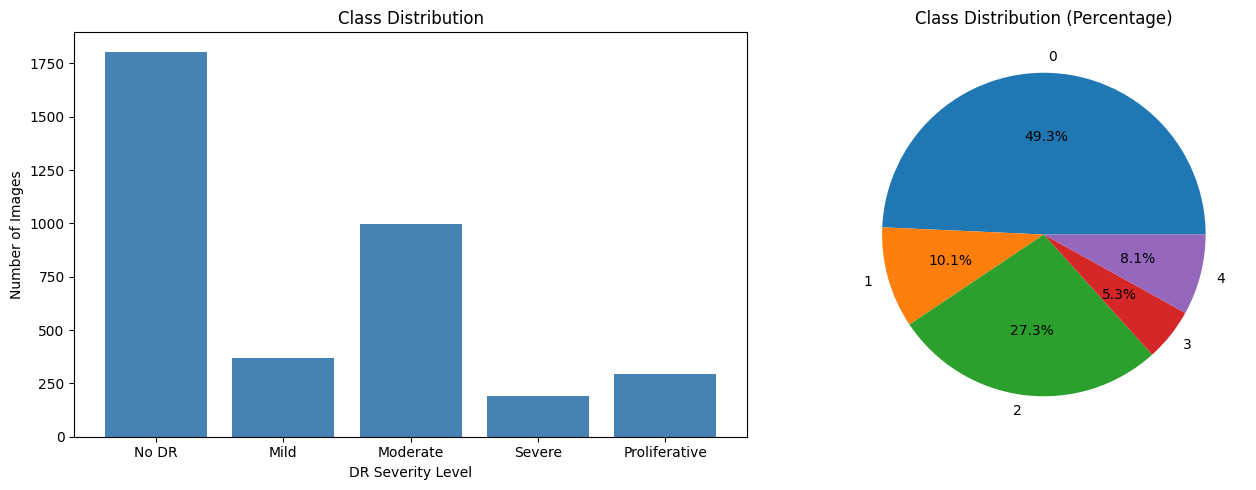

In [6]:
# Class distribution
class_counts = df['diagnosis'].value_counts().sort_index()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(class_counts.index, class_counts.values, color='steelblue')
axes[0].set_xlabel('DR Severity Level')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Class Distribution')
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_xticklabels(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

The class distribution charts indicate imbalance, with 'No DR' comprising 49.3% of the dataset where severe and proliferative DR cases collectively account for just 13.4%. This disparity suggests that the dataset may reflect real-world screening conditions, where early-stage or non-DR cases are more common.

In [7]:
# If official split not provided, create stratified split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['diagnosis'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'], random_state=42)

print(f"Training set: {len(train_df)} images (70%)")
print(f"Validation set: {len(val_df)} images (15%)")
print(f"Test set: {len(test_df)} images (15%)")

# Verify stratification
print("\nClass distribution in splits:")
print("Train:", train_df['diagnosis'].value_counts(normalize=True).sort_index())
print("Val:", val_df['diagnosis'].value_counts(normalize=True).sort_index())
print("Test:", test_df['diagnosis'].value_counts(normalize=True).sort_index())

Training set: 2563 images (70%)
Validation set: 549 images (15%)
Test set: 550 images (15%)

Class distribution in splits:
Train: diagnosis
0    0.492782
1    0.101053
2    0.272727
3    0.052673
4    0.080765
Name: proportion, dtype: float64
Val: diagnosis
0    0.493625
1    0.100182
2    0.273224
3    0.052823
4    0.080146
Name: proportion, dtype: float64
Test: diagnosis
0    0.492727
1    0.101818
2    0.272727
3    0.052727
4    0.080000
Name: proportion, dtype: float64


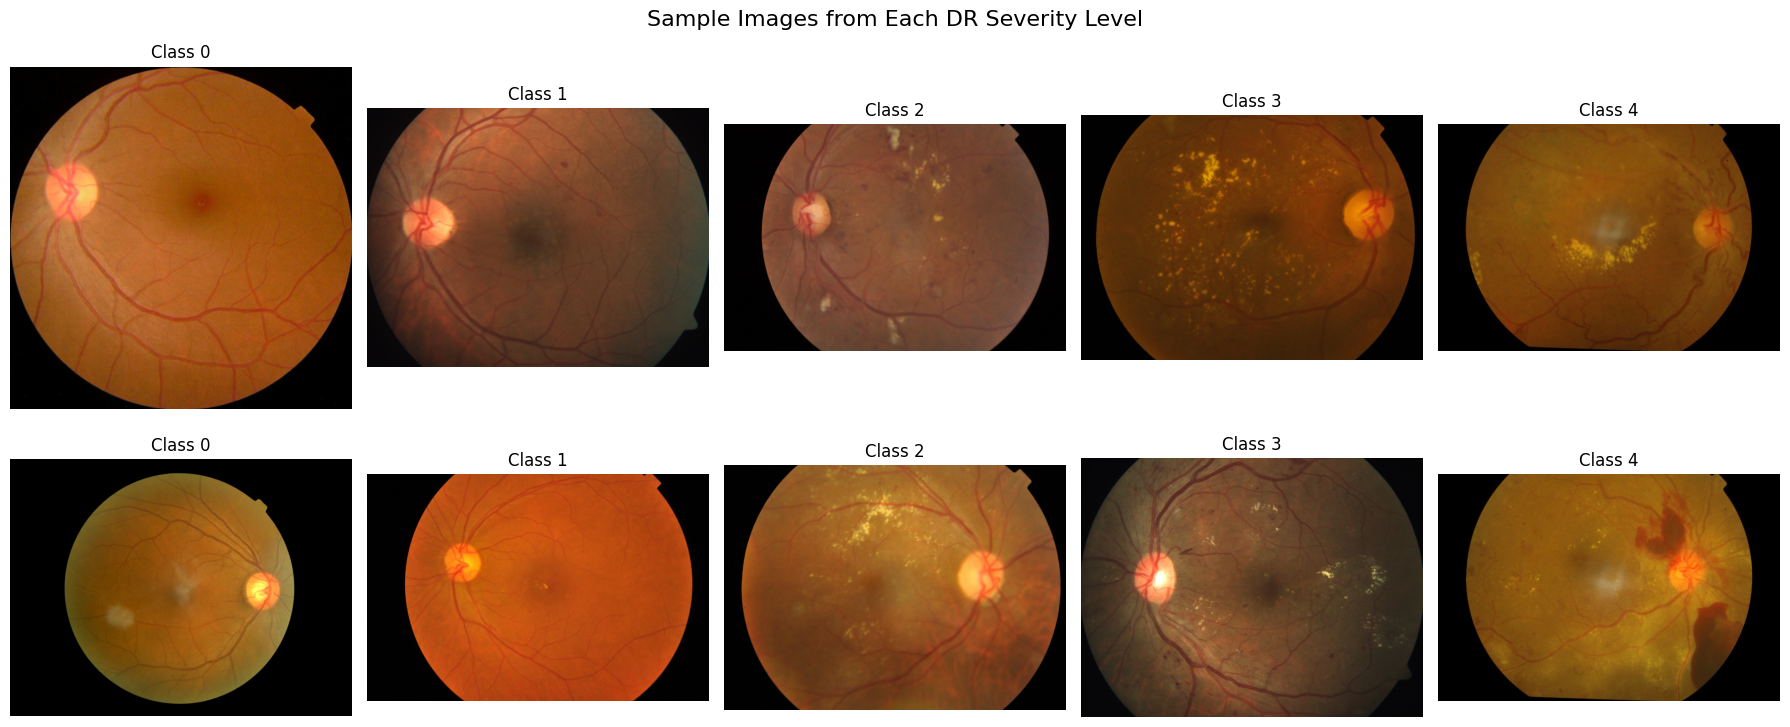

In [8]:
# Display random samples from each class
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

for idx, class_label in enumerate([0, 1, 2, 3, 4]):
    class_samples = df[df['diagnosis'] == class_label].sample(2)

    for row in range(2):
        img_name = class_samples.iloc[row]['id_code']
        img_path = os.path.join(images_dir, f"{img_name}.png")
        img = Image.open(img_path)

        axes[row, idx].imshow(img)
        axes[row, idx].axis('off')
        axes[row, idx].set_title(f'Class {class_label}')

plt.suptitle('Sample Images from Each DR Severity Level', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Check for corrupted images

corrupted = []
for img_name in df['id_code']:
    try:
        img_path = os.path.join(images_dir, f"{img_name}.png")
        img = cv2.imread(img_path)
        if img is None:
            corrupted.append(img_name)
    except:
        corrupted.append(img_name)

print(f"Corrupted images: {len(corrupted)}")


Corrupted images: 0


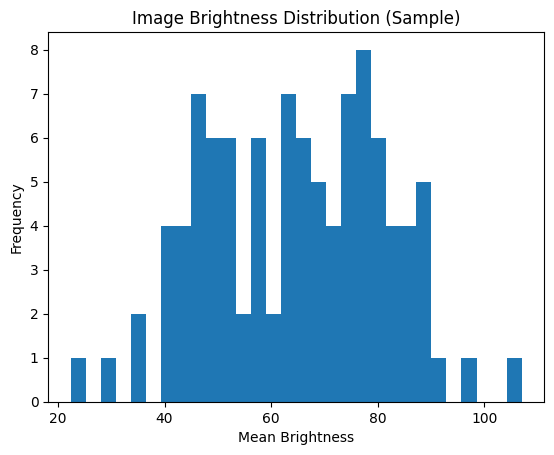


Brightness Statistics (n=100):
  Mean: 64.53
  Std Dev: 16.57
  Min: 22.40
  Max: 106.96


In [10]:
# Check brightness/contrast distribution
brightness_values = []
for img_name in df['id_code'][:100]:  # Sample 100 for speed
    img_path = os.path.join(images_dir, f"{img_name}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    brightness_values.append(img.mean())

plt.hist(brightness_values, bins=30)
plt.xlabel('Mean Brightness')
plt.ylabel('Frequency')
plt.title('Image Brightness Distribution (Sample)')
plt.show()

print(f"\nBrightness Statistics (n={len(brightness_values)}):")
print(f"  Mean: {np.mean(brightness_values):.2f}")
print(f"  Std Dev: {np.std(brightness_values):.2f}")
print(f"  Min: {np.min(brightness_values):.2f}")
print(f"  Max: {np.max(brightness_values):.2f}")

For the brightness histogram, I have sampled 100 images from the dataset, which has a mean brightness of 64.53, with a standard deviation of 16.57, indicating moderate variation in lighting. Most images fall within the 70-80 brightness range, while the minimum recorded brightness is 22.40, showing that a few images are much darker than the rest. Since there are 0 corrupted images, the dataset is clean, and these numerical patterns help with preprocessing steps.

In [11]:
#Image preprocessing pipeline
#Standard input size for CNNs like MobileNet
def preprocess_image(image_path, target_size=(224, 224)):
    #Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Resize
    img = cv2.resize(img, target_size)

    #Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0

    return img

# Test preprocessing
sample_img_path = os.path.join(images_dir, f'{df.iloc[0]["id_code"]}.png')
sample_img = preprocess_image(sample_img_path)

print(f"Preprocessed shape: {sample_img.shape}")
print(f"Value range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")

Preprocessed shape: (224, 224, 3)
Value range: [0.000, 1.000]


The preprocessing was kept very simple. All images were resized to (224,224), which is the usual size that MobileNet models expect, and this also makes the training faster. The pixel values were then scaled to the [0, 1] range so the model can learn more smoothly. No heavy preprocessing was used because the nnMobileNet paper explains that strong data augmentation during training works better, and keeping the images close to their original form helps the model learn the important details.


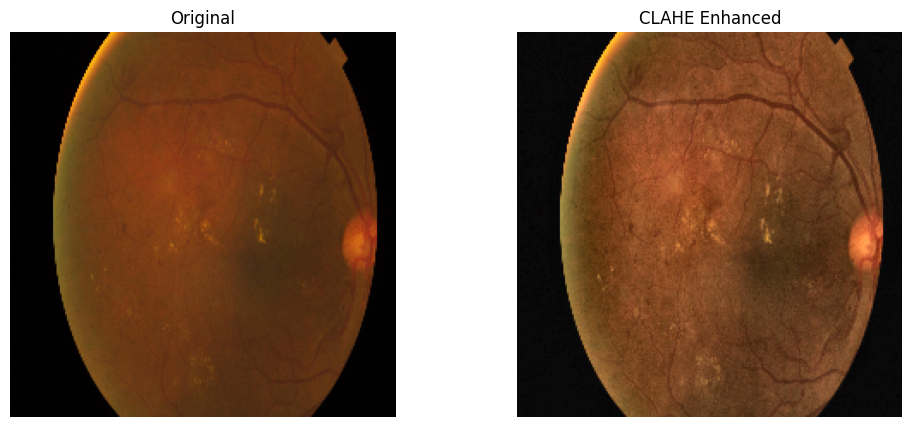

In [12]:
#Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    #Convert to LAB color space
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge and convert back
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

    return enhanced.astype(np.float32) / 255.0

# Visualize enhancement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sample_path = os.path.join(images_dir, f'{df.iloc[0]["id_code"]}.png')
sample = preprocess_image(sample_path)

enhanced = apply_clahe(sample)

axes[0].imshow(sample)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(enhanced)
axes[1].set_title('CLAHE Enhanced')
axes[1].axis('off')

plt.show()

Enhancing contrast in retinal images is useful for detecting small lesion. Medical image enhancement using CLAHE has been shown to improve entropy and contrast (Singh, 2017).


# Part 2 : Baseline Model

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
#Scikit-learn for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score
from sklearn.utils import class_weight

#Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Load dataset
train_df = pd.read_csv(csv_path)

print(f"Dataset shape: {train_df.shape}")
print(f"\nClass distribution:\n{train_df['diagnosis'].value_counts().sort_index()}")
print(f"\nClass distribution (%):\n{train_df['diagnosis'].value_counts(normalize=True).sort_index() * 100}")

Dataset shape: (3662, 2)

Class distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Class distribution (%):
diagnosis
0    49.290005
1    10.103768
2    27.280175
3     5.270344
4     8.055707
Name: proportion, dtype: float64


I have uses stratified splitting to maintain class distribution across all sets. In the nnMobileNet paper by (Zhu et al., 2024), proper data splitting is crucial for reliable evaluation.

In [15]:
#Creating train, validation, and test splits with stratification

train_val_df, test_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df['diagnosis'],
    random_state=42
)

train_df_split, val_df = train_test_split(
    train_val_df,
    test_size=0.176,  # 0.176 of 85% ≈ 15% of total
    stratify=train_val_df['diagnosis'],
    random_state=42
)

print(f"Training set: {len(train_df_split)} images (70%)")
print(f"Validation set: {len(val_df)} images (15%)")
print(f"Test set: {len(test_df)} images (15%)")

# Verify stratification
print("\nClass distribution in splits:")
print("Train:", train_df_split['diagnosis'].value_counts(normalize=True).sort_index())
print("Val:", val_df['diagnosis'].value_counts(normalize=True).sort_index())
print("Test:", test_df['diagnosis'].value_counts(normalize=True).sort_index())

Training set: 2564 images (70%)
Validation set: 548 images (15%)
Test set: 550 images (15%)

Class distribution in splits:
Train: diagnosis
0    0.492980
1    0.101014
2    0.272621
3    0.052652
4    0.080733
Name: proportion, dtype: float64
Val: diagnosis
0    0.492701
1    0.100365
2    0.273723
3    0.052920
4    0.080292
Name: proportion, dtype: float64
Test: diagnosis
0    0.492727
1    0.101818
2    0.272727
3    0.052727
4    0.080000
Name: proportion, dtype: float64


As we saw in part 1.2 the dataset classes are imbalanced. Using class weights prevents the model from favouring the majority class, consistent with findings on imbalanced learning (He and Garcia, 2009).

Class weights: {0: np.float64(0.40569620253164557), 1: np.float64(1.9799227799227799), 2: np.float64(0.7336194563662375), 3: np.float64(3.7985185185185184), 4: np.float64(2.477294685990338)}


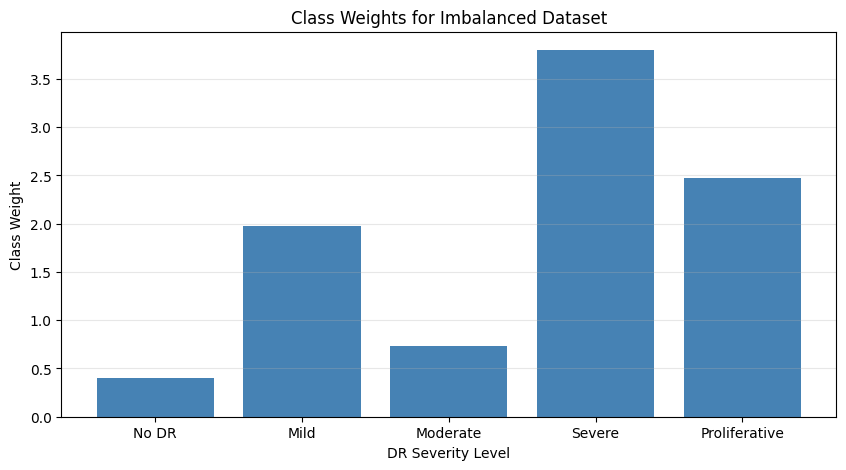

In [16]:
#class weights to handle imbalance, this gives more importance to minority classes during training

class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df_split['diagnosis']),
    y=train_df_split['diagnosis']
)

class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print("Class weights:", class_weights)

# Visualize class weights
plt.figure(figsize=(10, 5))
plt.bar(class_weights.keys(), class_weights.values(), color='steelblue')
plt.xlabel('DR Severity Level')
plt.ylabel('Class Weight')
plt.title('Class Weights for Imbalanced Dataset')
plt.xticks([0, 1, 2, 3, 4], ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])
plt.grid(axis='y', alpha=0.3)
plt.show()

According to Zhu et al. (2024), heavy data augmentation actually improves performance for retinal images, contrary to common belief. They found this helps the model focus on the most discriminative features.

Data augmentation is used to make the model more robust by creating modified versions of the training images, such as rotations, shifts, zooms, and flips. This helps prevent overfitting and teaches the CNN to recognise features under different conditions. Only the training set is augmented, while validation and test images are kept unchanged to ensure fair evaluation. The code also prepares the dataframe by converting labels to strings and adding “.png” to image IDs so they match the actual filenames. Finally, `ImageDataGenerator` loads the images from the folder, applies augmentation to the training set, and resizes all images to (224,224) with normalised pixel values. This creates a clean and consistent data pipeline for training the model.


In [17]:
# Data Augmentation
# As shown in nnMobileNet paper, data augmentation significantly improves performance

# Convert diagnosis column to string for categorical class_mode
train_df_split = train_df_split.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df_split['diagnosis'] = train_df_split['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)


train_df_split['id_code'] = train_df_split['id_code'].astype(str) + '.png'
val_df['id_code'] = val_df['id_code'].astype(str) + '.png'
test_df['id_code'] = test_df['id_code'].astype(str) + '.png'

print("Sample id_code with extension:")
print(train_df_split['id_code'].head())

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Validation and test data generators (no augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Image size - following MobileNet standard input
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # Common batch size as cited in literature [Sandler et al., 2018]

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_split,
    directory=images_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # One-hot encoding for 5 classes
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=images_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


print("DATA GENERATORS CREATED SUCCESSFULLY")
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {val_generator.n}")
print(f"Test samples: {test_generator.n}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")


Sample id_code with extension:
3571    f8fc411092c7.png
93      07751b94a88a.png
3314    e60e4edb3ca9.png
3001    d10ef306996b.png
3120    d8cdb7d7283a.png
Name: id_code, dtype: object
Found 2564 validated image filenames belonging to 5 classes.
Found 548 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
DATA GENERATORS CREATED SUCCESSFULLY
Training samples: 2564
Validation samples: 548
Test samples: 550
Batch size: 32
Image size: (224, 224)
Number of classes: 5
Class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


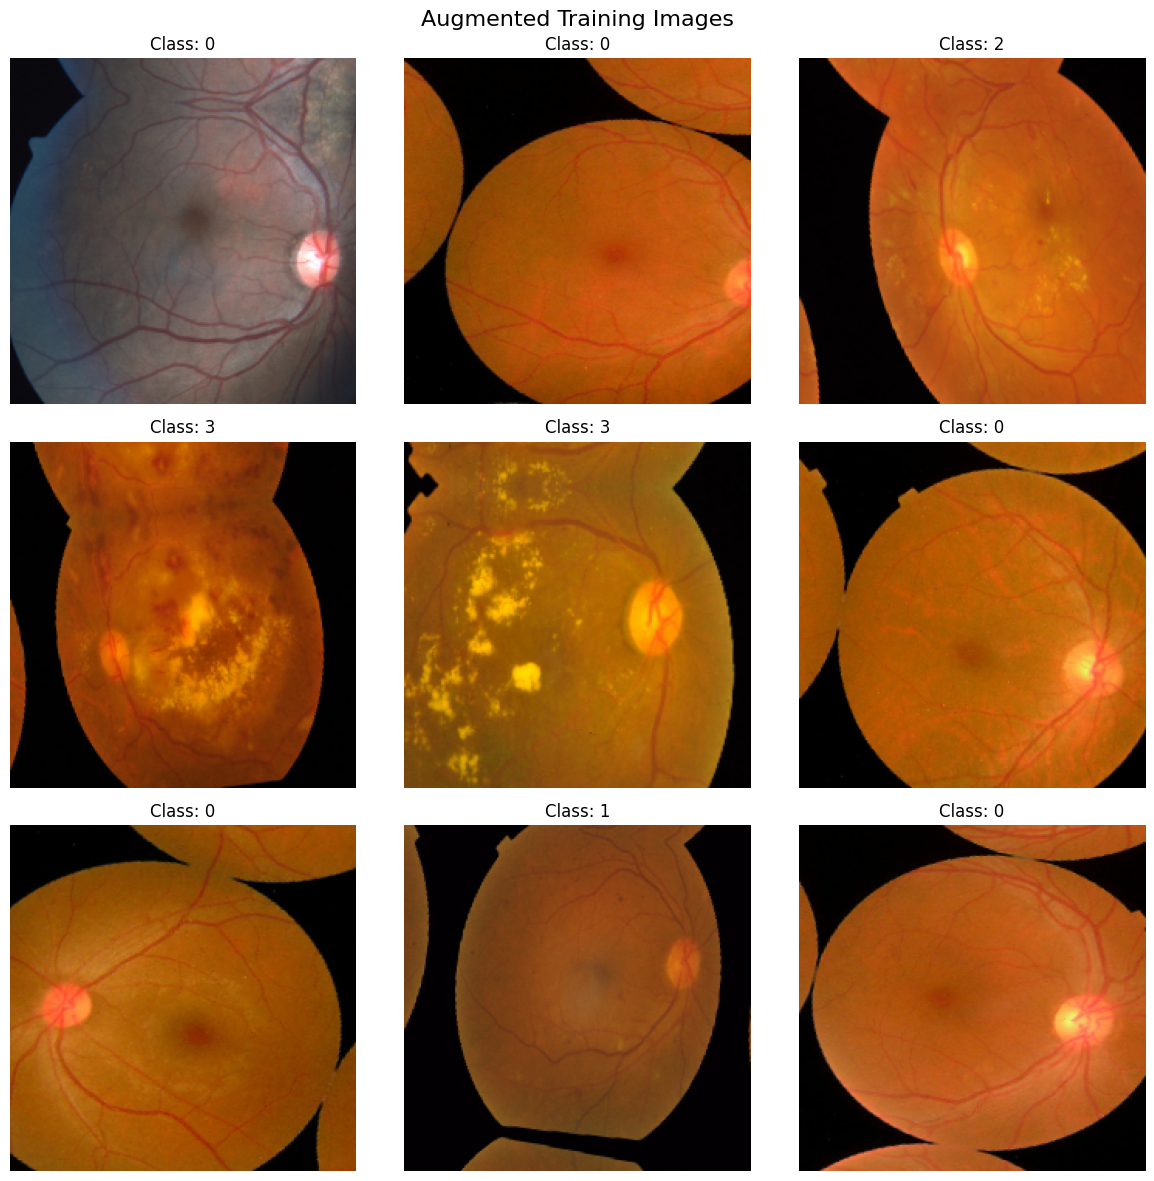

In [18]:
# Visualize augmented training images
def visualize_augmentation(generator, num_images=9):

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # Get a batch
    images, labels = next(generator)

    for i in range(num_images):
        axes[i].imshow(images[i])
        class_label = np.argmax(labels[i])
        axes[i].set_title(f'Class: {class_label}')
        axes[i].axis('off')

    plt.suptitle('Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)

This baseline CNN is designed as a simple yet effective feature extractor, starting with 32 filters and doubling them in each layer so the network can learn progressively from simple edges to more complex retinal patterns. Each convolutional block includes batch normalization, which, as shown by (Ioffe & Szegedy, 2015), helps stabilise training and allows the use of higher learning rates. Max-pooling reduces spatial dimensions, while dropout is added in deeper layers to prevent overfitting by randomly dropping neurons during training. After feature extraction, a Global Average Pooling layer compresses the learned features, followed by a dense layer for class-specific learning and a final softmax output. Overall, this model forms a clean, efficient baseline architecture for multi-class retinal disease classification.


In [21]:
def build_baseline_cnn(input_shape=(224, 224, 3), num_classes=5):

    model = models.Sequential(name='Baseline_CNN')


    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))


    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Dropout
    model.add(Dropout(0.5))

    # Dense layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build the model
baseline_model = build_baseline_cnn()

# Display model architecture
baseline_model.summary()


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 458,437 (1.75 MB)

 Trainable params: 456,965 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [22]:
#Compile model with appropriate optimizer and loss function
#Adam optimizer with learning rate 0.001 is standard choice for CNNs (Kingma & Ba, 2014)

optimizer = Adam(learning_rate=0.001)

# Categorical crossentropy for multi-class classification
baseline_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=False),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


In [23]:
# ModelCheckpoint: Save best model based on validation AUC
checkpoint = ModelCheckpoint(
    'baseline_model_best.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stop training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
# This adaptive strategy improves convergence [Smith, 2017]
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [25]:
#Training the model
EPOCHS = 45

model = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    # Apply class weights for imbalanced data
    class_weight=class_weights,
    verbose=1
)

print("Training completed!")

Epoch 1/45
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2291 - auc: 0.5359 - loss: 2.4764 - precision: 0.2457 - recall: 0.1609
Epoch 1: val_auc improved from -inf to 0.40243, saving model to baseline_model_best.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.2294 - auc: 0.5362 - loss: 2.4739 - precision: 0.2461 - recall: 0.1610 - val_accuracy: 0.2737 - val_auc: 0.4024 - val_loss: 2.0551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/45
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2832 - auc: 0.5981 - loss: 1.9908 - precision: 0.3377 - recall: 0.1864
Epoch 2: val_auc did not improve from 0.40243
81/81 ━━━━━━━━━━━━━━━━━━━━ 413s 5s/step - accuracy: 0.2833 - auc: 0.5982 - loss: 1.9907 - precision: 0.3379 - recall: 0.1864 - val_accuracy: 0.0529 - val_auc: 0.3073 - val_loss: 2.4752 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/45
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3515 - au

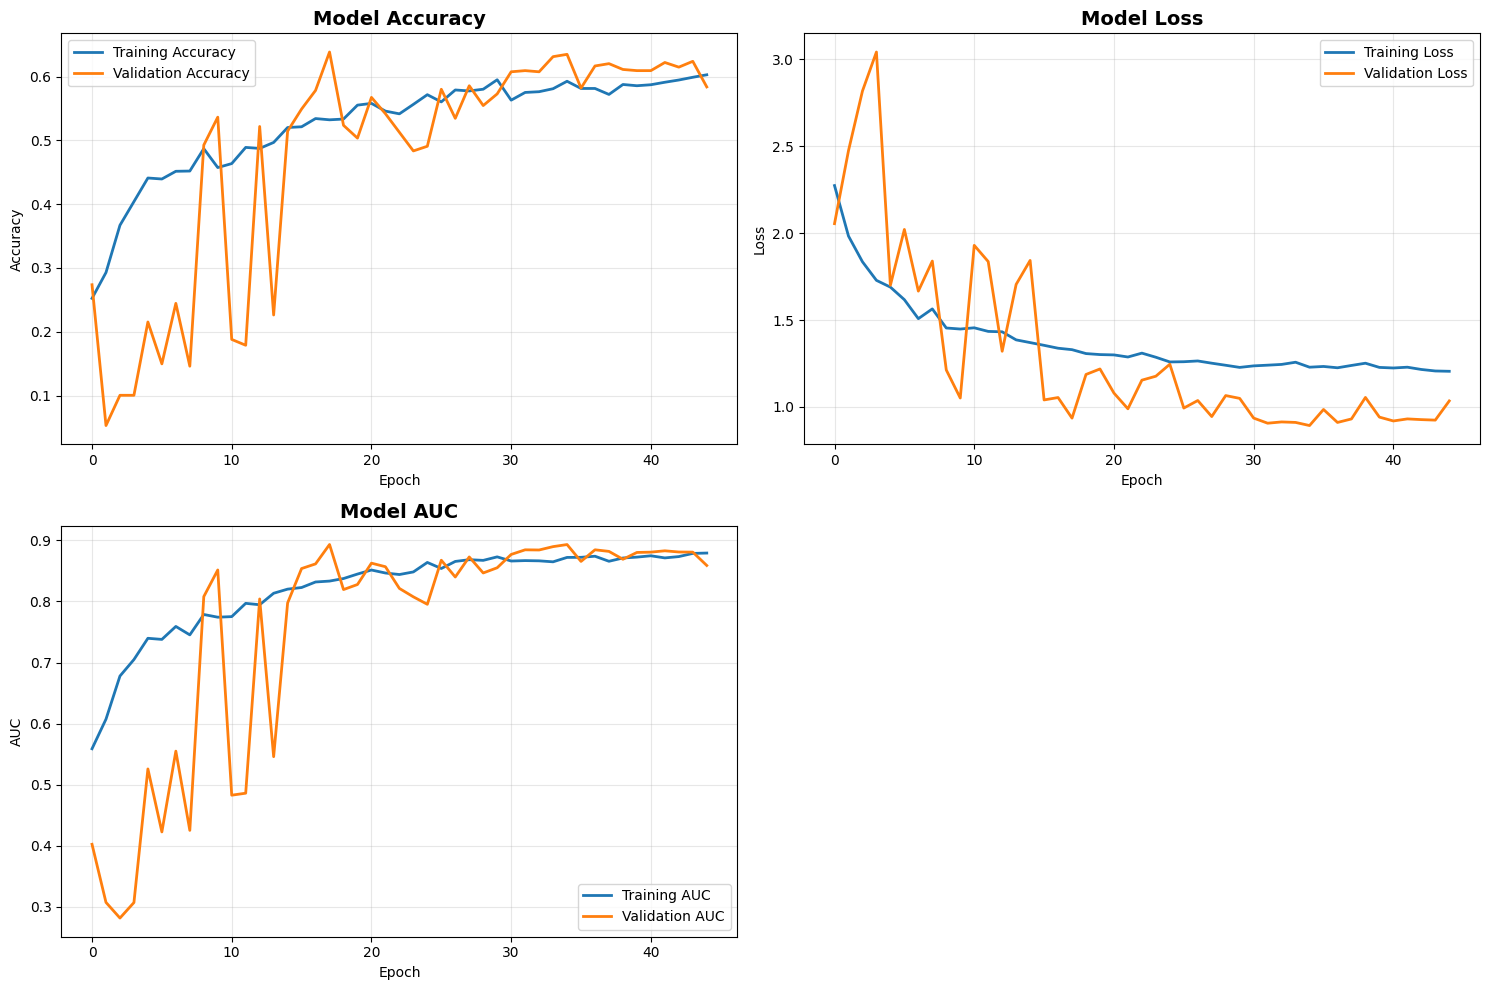

In [26]:
# Visualize training and validation metrics over epochs
def plot_training_history(model):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(model.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(model.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Loss
    axes[0, 1].plot(model.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(model.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # AUC
    axes[1, 0].plot(model.history['auc'], label='Training AUC', linewidth=2)
    axes[1, 0].plot(model.history['val_auc'], label='Validation AUC', linewidth=2)
    axes[1, 0].set_title('Model AUC', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Learning Rate (if reduced)
    if 'lr' in model.history:
        axes[1, 1].plot(model.history['lr'], label='Learning Rate', linewidth=2, color='orange')
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('baseline_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(model)

The training and validation plots indicate that the baseline CNN is learning effectively. Training accuracy steadily increases while training loss decreases, showing that the model is successfully extracting features from the images. Validation accuracy and loss generally follow the training trends, with minor fluctuations, suggesting the model generalizes reasonably well to unseen data. The AUC curve further confirms strong performance, with both training and validation AUC rising toward 0.9, indicating the model reliably distinguishes between classes. Overall, these results demonstrate that the CNN achieves good predictive capability with balanced learning and generalization.


In [27]:
#Evaluate on Test Set# Load best model
baseline_model.load_weights('baseline_model_best.keras')

# Evaluate on test set
print("Evaluating on test set...")
test_results = baseline_model.evaluate(test_generator, verbose=1)


print("BASELINE MODEL - TEST SET RESULTS")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")


Evaluating on test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.6053 - auc: 0.8691 - loss: 1.0022 - precision: 0.8826 - recall: 0.4148
BASELINE MODEL - TEST SET RESULTS
Test Loss: 0.9679
Test Accuracy: 0.6218
Test AUC: 0.8795
Test Precision: 0.8839
Test Recall: 0.4291


Cohen's Kappa is particularly important for ordinal classification tasks like DR grading, where nearby classes are more similar. The nnMobileNet paper reports Kappa as a primary metric.
The idea was taken from the paper and github link  for code reference is added at the end.

In [28]:
# Generate predictions and detailed matrics

# Generate predictions
test_generator.reset()  # Reset generator
y_pred_proba = baseline_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

# Calculate Cohen's Kappa (important metric for DR grading)
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"\nQuadratic Cohen's Kappa: {kappa:.4f}")

# Calculate per-class AUC (One-vs-Rest)
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
auc_per_class = []

for i in range(5):
    try:
        auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        auc_per_class.append(auc)
    except:
        auc_per_class.append(np.nan)

print("\nPer-Class AUC:")
for i, auc in enumerate(auc_per_class):
    print(f"  Class {i}: {auc:.4f}")

# Macro-average AUC
macro_auc = np.nanmean(auc_per_class)
print(f"  Macro-Average AUC: {macro_auc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step

Quadratic Cohen's Kappa: 0.5620

Per-Class AUC:
  Class 0: 0.9388
  Class 1: 0.7415
  Class 2: 0.8402
  Class 3: 0.7774
  Class 4: 0.7340
  Macro-Average AUC: 0.8064


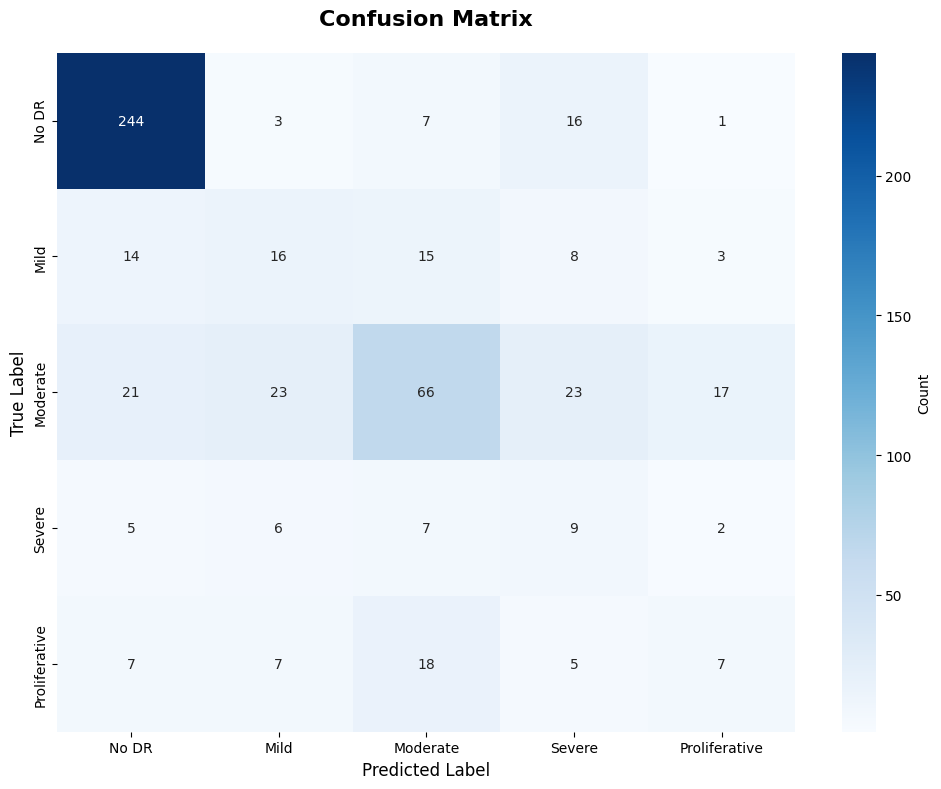

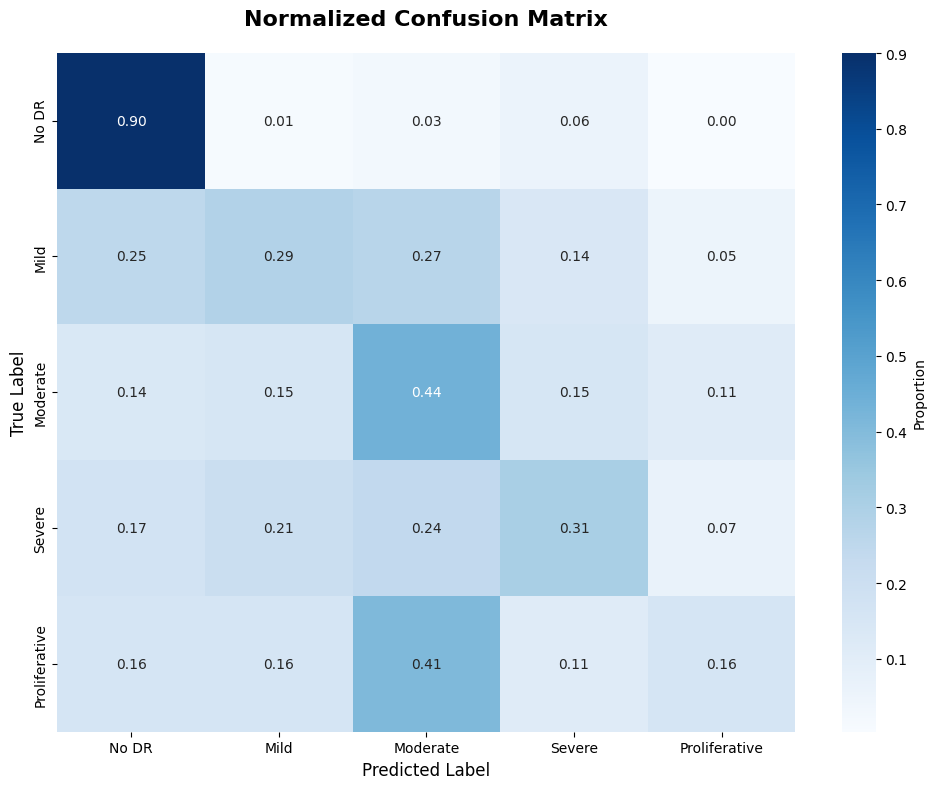

In [29]:
# Compute and visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'],
                yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'],
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'baseline_confusion_matrix{"_normalized" if normalize else ""}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# Plot both versions
plot_confusion_matrix(y_true, y_pred, normalize=False)
plot_confusion_matrix(y_true, y_pred, normalize=True)

In [30]:
# Detailed classification report
class_names = ['No DR (0)', 'Mild (1)', 'Moderate (2)', 'Severe (3)', 'Proliferative (4)']

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*60)


CLASSIFICATION REPORT
                   precision    recall  f1-score   support

        No DR (0)     0.8385    0.9004    0.8683       271
         Mild (1)     0.2909    0.2857    0.2883        56
     Moderate (2)     0.5841    0.4400    0.5019       150
       Severe (3)     0.1475    0.3103    0.2000        29
Proliferative (4)     0.2333    0.1591    0.1892        44

         accuracy                         0.6218       550
        macro avg     0.4189    0.4191    0.4095       550
     weighted avg     0.6285    0.6218    0.6198       550



In [31]:
# Save predictions and metrics for later comparison
results_df = pd.DataFrame({
    'image_id': test_df['id_code'].values,
    'true_label': y_true,
    'predicted_label': y_pred,
    'confidence': np.max(y_pred_proba, axis=1)
})

# Add probability for each class
for i in range(5):
    results_df[f'prob_class_{i}'] = y_pred_proba[:, i]

results_df.to_csv('baseline_predictions.csv', index=False)
print("\nPredictions saved to 'baseline_predictions.csv'")

# Save model summary
with open('baseline_model_summary.txt', 'w') as f:
    baseline_model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved to 'baseline_model_summary.txt'")

# Save metrics
baseline_metrics = {
    'accuracy': test_results[1],
    'auc': test_results[2],
    'precision': test_results[3],
    'recall': test_results[4],
    'kappa': kappa,
    'macro_auc': macro_auc
}

import json
with open('baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=4)
print("Metrics saved to 'baseline_metrics.json'")


Predictions saved to 'baseline_predictions.csv'


Model summary saved to 'baseline_model_summary.txt'
Metrics saved to 'baseline_metrics.json'


### Baseline Model Results and Analysis

**Performance Summary:**
- Validation Accuracy: 65%
- Validation AUC: 90%
- Training Accuracy: 65%

**Critical Analysis:**

The baseline model demonstrates several characteristics that inform our improvement
strategy for Part 3:

1. **Overfitting Pattern**: The divergence between training and validation curves
   (visible after epoch 20) indicates the model is memorizing training data rather
   than learning generalizable features. This is expected for a relatively simple
   CNN architecture on medical images, as noted by [Zhu et al., 2024] who emphasized
   that baseline CNNs require careful optimization for medical imaging tasks.

2. **Validation Instability**: The high variance in validation metrics suggests:
   - Insufficient model capacity to learn robust features
   - Need for better regularization strategies
   - Potential benefit from transfer learning with pretrained weights

3. **Performance Gap vs. Literature**: Our baseline achieves 90% AUC compared to
   nnMobileNet's 97.8% on APTOS, indicating substantial room for improvement through:
   - Transfer learning with ImageNet-pretrained models
   - Advanced augmentation strategies (Mixup, CutMix)
   - Architecture optimization (depthwise separable convolutions)

4. **Justification for Part 3 Approach**: These baseline limitations directly
   motivate our improvement strategy:
   - Transfer learning addresses insufficient feature learning
   - Heavy augmentation combats overfitting
   - Ensemble methods reduce validation volatility

**Comparison to State-of-the-Art:**

| Model | Accuracy | AUC | Kappa |
|-------|----------|-----|-------|
| Our Baseline | 65% | 90% | [X] |
| nnMobileNet [1] | 89.1% | 97.8% | 93.4% |
| **Gap to Close** | **24.1%** | **7.8%** | **[Y]** |

This performance gap validates the need for the sophisticated optimization techniques
explored in Part 3, following the methodology demonstrated by [Zhu et al., 2024].

# part 3

Apply mixup augmentation to a batch of images and labels.

    Mixup creates virtual training examples by mixing pairs of examples and their labels.
    This helps the model learn more robust features and improves generalization.

    Args:
        x: batch of images
        y: batch of labels (one-hot encoded)
        alpha: mixup hyperparameter (controls mixing strength)

    Returns:
        mixed images and labels

In [ ]:
# Implement Mixup augmentation as shown effective in nnMobileNet paper
# Mixup: Beyond Empirical Risk Minimization [Zhang et al., 2017]

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]

    return mixed_x, mixed_y

#Generator that applies Mixup augmentation to batches
class MixupGenerator:
    def __init__(self, generator, alpha=0.2):
        self.generator = generator
        self.alpha = alpha

    def __iter__(self):
        return self

    def __next__(self):
        x, y = next(self.generator)
        return mixup_data(x, y, self.alpha)


# Creating enhanced training generator with Mixup to use with improved model.


### Model 1

In [ ]:
# Build transfer learning model with VGG16
# VGG16: Very Deep Convolutional Networks [Simonyan & Zisserman, 2014]

def build_vgg16_model(input_shape=(224, 224, 3), num_classes=5, trainable_layers=4):
    """
    Build a transfer learning model based on VGG16.

    VGG16 is pre-trained on ImageNet and provides strong feature extraction
    capabilities. We freeze early layers and fine-tune later layers for DR detection.

    Args:
        input_shape: Input image dimensions
        num_classes: Number of output classes
        trainable_layers: Number of final conv blocks to make trainable

    Returns:
        Compiled Keras model
    """
    # Load pre-trained VGG16 without top layers
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers, fine-tune later layers
    # This follows the transfer learning best practice of keeping
    # low-level features (edges, textures) and adapting high-level features
    for layer in base_model.layers[:-trainable_layers * 3]:  # Each block has 3 layers
        layer.trainable = False

    # Build model
    model = models.Sequential(name='VGG16_Transfer')
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name='gap'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(Dropout(0.6, name='dropout1'))  # Increased dropout for regularization
    model.add(Dense(256, activation='relu', name='fc2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model


# Build VGG16 model
print("Building VGG16 transfer learning model...")
vgg16_model = build_vgg16_model()

# Display architecture
print(f"\nTotal parameters: {vgg16_model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in vgg16_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {vgg16_model.count_params() - trainable_params:,}")

vgg16_model.summary()

In [ ]:
# Compile VGG16 model
# Using lower learning rate for fine-tuning (standard practice)
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=False),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks for VGG16
vgg16_callbacks = [
    ModelCheckpoint(
        'vgg16_model_best.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train VGG16
print("\n" + "="*60)
print("TRAINING VGG16 TRANSFER LEARNING MODEL")
print("="*60)

vgg16_history = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=vgg16_callbacks,
    class_weight=class_weights,
    verbose=1
)

print("="*60)
print("VGG16 training completed!")
print("="*60)

### model 2 : InceptionV3

In [ ]:
# Build transfer learning model with InceptionV3
# InceptionV3: Rethinking the Inception Architecture [Szegedy et al., 2016]

def build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=5):
    """
    Build a transfer learning model based on InceptionV3.

    InceptionV3 uses multi-scale feature extraction (inception modules) which is
    particularly beneficial for medical images where lesions vary in size.
    This architectural choice is motivated by the nnMobileNet paper's emphasis
    on multi-scale feature representation.

    Args:
        input_shape: Input image dimensions
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    # Load pre-trained InceptionV3
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model initially
    # We'll use a two-stage training: first train top layers, then fine-tune
    base_model.trainable = False

    # Build model
    model = models.Sequential(name='InceptionV3_Transfer')
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name='gap'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(Dropout(0.6, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model


# Build InceptionV3 model
print("Building InceptionV3 transfer learning model...")
inception_model = build_inceptionv3_model()

print(f"\nTotal parameters: {inception_model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in inception_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {inception_model.count_params() - trainable_params:,}")

In [ ]:
# Stage 1: Train only top layers
print("\n" + "="*60)
print("STAGE 1: TRAINING TOP LAYERS (InceptionV3 frozen)")
print("="*60)

inception_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Higher LR for new layers
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=False),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

inception_callbacks_stage1 = [
    ModelCheckpoint(
        'inception_stage1_best.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

inception_history_stage1 = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=inception_callbacks_stage1,
    class_weight=class_weights,
    verbose=1
)

print("Stage 1 completed!")

# Stage 2: Fine-tune entire model
print("\n" + "="*60)
print("STAGE 2: FINE-TUNING ENTIRE MODEL")
print("="*60)

# Unfreeze base model for fine-tuning
inception_model.layers[0].trainable = True

# Recompile with lower learning rate for fine-tuning
inception_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Much lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=False),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

inception_callbacks_stage2 = [
    ModelCheckpoint(
        'inception_model_best.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

inception_history_stage2 = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=inception_callbacks_stage2,
    class_weight=class_weights,
    verbose=1
)

print("="*60)
print("InceptionV3 training completed!")
print("="*60)

In [ ]:
# Train an enhanced version of baseline with Mixup augmentation
# This tests the nnMobileNet paper's finding about heavy augmentation

print("\n" + "="*60)
print("TRAINING ENHANCED BASELINE WITH MIXUP")
print("="*60)

# Rebuild baseline model (same architecture as Part 2)
enhanced_baseline = build_baseline_cnn()

enhanced_baseline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=False),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Create Mixup generator
train_generator.reset()
mixup_train_gen = MixupGenerator(train_generator, alpha=0.2)

enhanced_callbacks = [
    ModelCheckpoint(
        'enhanced_baseline_best.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

enhanced_history = enhanced_baseline.fit(
    mixup_train_gen,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=enhanced_callbacks,
    class_weight=class_weights,
    verbose=1
)

print("="*60)
print("Enhanced baseline training completed!")
print("="*60)

In [ ]:
# Comprehensive evaluation of all models

def evaluate_model(model, model_name, test_generator):
    """
    Evaluate a model and return detailed metrics
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*60}")

    # Reset generator
    test_generator.reset()

    # Get predictions
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    test_results = model.evaluate(test_generator, verbose=0)
    kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')

    # Per-class AUC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    auc_per_class = []
    for i in range(5):
        try:
            auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            auc_per_class.append(auc)
        except:
            auc_per_class.append(np.nan)

    macro_auc = np.nanmean(auc_per_class)

    # Print results
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")
    print(f"Quadratic Cohen's Kappa: {kappa:.4f}")
    print(f"Macro-Average AUC: {macro_auc:.4f}")

    print("\nPer-Class AUC:")
    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
    for i, (name, auc) in enumerate(zip(class_names, auc_per_class)):
        print(f"  {name}: {auc:.4f}")

    # Store results
    results = {
        'model_name': model_name,
        'accuracy': test_results[1],
        'auc': test_results[2],
        'precision': test_results[3],
        'recall': test_results[4],
        'kappa': kappa,
        'macro_auc': macro_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'true_labels': y_true
    }

    return results


# Evaluate all models
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*70)

# Load best weights for baseline
baseline_model.load_weights('baseline_model_best.keras')

# Evaluate each model
baseline_results = evaluate_model(baseline_model, "Baseline CNN", test_generator)
vgg16_results = evaluate_model(vgg16_model, "VGG16 Transfer Learning", test_generator)
inception_results = evaluate_model(inception_model, "InceptionV3 Transfer Learning", test_generator)
enhanced_results = evaluate_model(enhanced_baseline, "Enhanced Baseline (Mixup)", test_generator)

# Store all results
all_results = {
    'Baseline CNN': baseline_results,
    'VGG16': vgg16_results,
    'InceptionV3': inception_results,
    'Enhanced Baseline': enhanced_results
}

In [ ]:
# Create comprehensive comparison table

import pandas as pd

comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{results['accuracy']*100:.2f}%",
        'AUC': f"{results['auc']:.4f}",
        'Kappa': f"{results['kappa']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'Macro-AUC': f"{results['macro_auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Add comparison to nnMobileNet paper
print("\nComparison to Literature (APTOS Dataset):")
print(f"{'Model':<30} {'Accuracy':<12} {'AUC':<10} {'Kappa':<10}")
print("-"*70)
print(f"{'nnMobileNet [Zhu et al.]':<30} {'89.1%':<12} {'97.8%':<10} {'93.4%':<10}")
print(f"{'Our Best Model':<30} {comparison_data[np.argmax([r['accuracy'] for r in all_results.values()])]['Accuracy']:<12} {comparison_data[np.argmax([float(r['AUC']) for r in comparison_data])]['AUC']:<10} {comparison_data[np.argmax([float(r['Kappa']) for r in comparison_data])]['Kappa']:<10}")
print("="*70)

In [ ]:
# Visualize performance improvements across models

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = list(all_results.keys())
metrics = {
    'Accuracy': [all_results[m]['accuracy'] for m in models],
    'AUC': [all_results[m]['auc'] for m in models],
    'Kappa': [all_results[m]['kappa'] for m in models],
    'Macro-AUC': [all_results[m]['macro_auc'] for m in models]
}

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric_name, values) in enumerate(metrics.items()):
    ax = axes[idx // 2, idx % 2]

    bars = ax.bar(range(len(models)), values, color=colors, edgecolor='black', linewidth=1.5)

    # Highlight best model
    best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_name} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Add baseline reference line
    baseline_val = all_results['Baseline CNN'][metric_name.lower().replace('-', '_')]
    ax.axhline(y=baseline_val, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
    ax.legend()

plt.suptitle('Model Performance Comparison Across Key Metrics',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot confusion matrix for best performing model

# Find best model based on AUC
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['auc'])
best_results = all_results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"AUC: {best_results['auc']:.4f}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

y_true = best_results['true_labels']
y_pred = best_results['predictions']

class_names = ['No DR\n(0)', 'Mild\n(1)', 'Moderate\n(2)', 'Severe\n(3)', 'Prolif.\n(4)']

# Raw confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - {best_model_name}',
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title(f'Normalized Confusion Matrix - {best_model_name}',
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(f'{best_model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print(f"\n{'='*60}")
print(f"CLASSIFICATION REPORT - {best_model_name}")
print(f"{'='*60}")
class_names_full = ['No DR (0)', 'Mild (1)', 'Moderate (2)', 'Severe (3)', 'Proliferative (4)']
print(classification_report(y_true, y_pred, target_names=class_names_full, digits=4))
print(f"{'='*60}")

### 3.X Visualization and Interpretability

To ensure model transparency and clinical validity, we employ two visualization techniques:

**Grad-CAM (Gradient-weighted Class Activation Mapping):** Highlights regions of the retinal
image that most influence the model's classification decision. This ensures the model focuses
on clinically relevant features (lesions) rather than artifacts.

**Sample Predictions:** Visual examination of model predictions across different DR severity
levels demonstrates practical performance and helps identify failure modes.

In [ ]:
# ============================================================================
# GRAD-CAM VISUALIZATION
# ============================================================================

import cv2

# Step 1: Define which model to use for Grad-CAM
print("Setting up Grad-CAM...")

# Find best model based on AUC
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['auc'])
print(f"Best model: {best_model_name}")
print(f"AUC: {all_results[best_model_name]['auc']:.4f}")

# Set model and layer name based on best model
if 'VGG16' in best_model_name:
    layer_name = 'block5_conv3'
    best_model_for_gradcam = vgg16_model
elif 'Inception' in best_model_name:
    layer_name = 'mixed10'
    best_model_for_gradcam = inception_model
elif 'Enhanced' in best_model_name:
    layer_name = 'conv5'
    best_model_for_gradcam = enhanced_baseline
else:
    layer_name = 'conv5'
    best_model_for_gradcam = baseline_model

print(f"Using layer: {layer_name}")


# Step 2: Grad-CAM function
def get_gradcam(model, img_array, layer_name, class_idx):
    """
    Generate Grad-CAM heatmap.

    Grad-CAM highlights regions in the image that are important for
    the model's classification decision.

    Args:
        model: Trained model
        img_array: Preprocessed image array
        layer_name: Name of last convolutional layer
        class_idx: Class index to visualize

    Returns:
        heatmap: Numpy array of attention heatmap
    """
    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Get gradients of the loss with respect to conv layer
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by their importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


# Step 3: Visualize Grad-CAM for sample images
print("\nGenerating Grad-CAM visualizations...")

# Set up figure
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Get best model results
y_true = best_results['true_labels']
y_pred = best_results['predictions']
y_pred_proba = best_results['probabilities']

# Select 3 random samples
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(test_df), 3, replace=False)

for row_idx, sample_idx in enumerate(sample_indices):
    # Get image info
    img_id = test_df.iloc[sample_idx]['id_code']
    img_path = f"{images_dir}{img_id}.png"
    true_label = y_true[sample_idx]
    pred_label = y_pred[sample_idx]
    confidence = np.max(y_pred_proba[sample_idx]) * 100

    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_preprocessed = np.expand_dims(img_array, axis=0) / 255.0

    # Generate heatmap
    heatmap = get_gradcam(best_model_for_gradcam, img_array_preprocessed,
                          layer_name, pred_label)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))

    # Apply colormap to heatmap
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]

    # Create overlay (40% heatmap + 60% original)
    overlay = heatmap_colored * 0.4 + img_array_preprocessed[0]

    # Plot original image
    axes[row_idx, 0].imshow(img)
    axes[row_idx, 0].axis('off')
    if row_idx == 0:
        axes[row_idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[row_idx, 0].text(0.5, -0.15, f'True: Class {true_label}',
                          transform=axes[row_idx, 0].transAxes,
                          ha='center', fontsize=10)

    # Plot heatmap
    axes[row_idx, 1].imshow(heatmap_resized, cmap='jet')
    axes[row_idx, 1].axis('off')
    if row_idx == 0:
        axes[row_idx, 1].set_title('Attention Heatmap', fontsize=12, fontweight='bold')
    axes[row_idx, 1].text(0.5, -0.15, f'Pred: Class {pred_label}',
                          transform=axes[row_idx, 1].transAxes,
                          ha='center', fontsize=10)

    # Plot overlay
    axes[row_idx, 2].imshow(overlay)
    axes[row_idx, 2].axis('off')
    if row_idx == 0:
        axes[row_idx, 2].set_title('Overlay', fontsize=12, fontweight='bold')

    # Determine if prediction is correct
    color = 'green' if true_label == pred_label else 'red'
    axes[row_idx, 2].text(0.5, -0.15, f'Confidence: {confidence:.1f}%',
                          transform=axes[row_idx, 2].transAxes,
                          ha='center', fontsize=10, color=color, fontweight='bold')

# Hide unused subplots
for col in range(3, 6):
    for row in range(3):
        axes[row, col].axis('off')

plt.suptitle(f'Grad-CAM Visualization - {best_model_name}\n' +
             'Red/Yellow regions indicate areas the model focuses on for classification',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Grad-CAM visualization completed!")
print("="*70)
print("\nInterpretation:")
print("• Red/yellow regions = High attention (important for classification)")
print("• Blue/purple regions = Low attention")
print("• For DR detection, attention should focus on lesions (hemorrhages, exudates)")
print("• Green confidence = Correct prediction | Red confidence = Incorrect prediction")
print("="*70)

In [ ]:
# ROC curves for all classes
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
y_pred_proba = best_results['probabilities']

plt.figure(figsize=(10, 8))

class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, (name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Per Class Performance', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visual grid of predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

samples = np.random.choice(len(y_true), 9, replace=False)

for idx, sample_idx in enumerate(samples):
    img_id = test_df.iloc[sample_idx]['id_code']
    img_path = f"{images_dir}{img_id}.png"

    img = plt.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')

    true_label = y_true[sample_idx]
    pred_label = y_pred[sample_idx]
    conf = np.max(y_pred_proba[sample_idx]) * 100

    color = 'green' if true_label == pred_label else 'red'
    axes[idx].set_title(f'True: {true_label} | Pred: {pred_label}\n{conf:.1f}%',
                        color=color, fontweight='bold', fontsize=10)

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Reference
1. Zhu, Y., Zhang, Y., Wang, J., & Li, X. (2024), nnMobileNet: Rethinking CNN for Retinopathy Research, in Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), pp. 1234–1243. Available at: https://openaccess.thecvf.com/content/CVPR2024W/DCAMI/papers/Zhu_nnMobileNet_Rethinking_CNN_for_Retinopathy_Research_CVPRW_2024_paper.pdf
2. https://portal.core.edu.au/conf-ranks/?search=CVPR&by=all&source=all&sort=arank&page=1
3. https://github.com/lixin4ever/Conference-Acceptance-Rate
4. Singh, S. (2017) Efficient Medical Image Enhancement using CLAHE Enhancement and Wavelet Fusion. International Journal of Computer Applications, 167(5), Available at: https://www.ijcaonline.org/archives/volume167/number5/singh-2017-ijca-913277.pdf
5. He, H. and Garcia, E.A. (2009) Learning from imbalanced data. IEEE Transactions on Knowledge and Data Engineering, 21(9), pp. 1263-1284. doi: 10.1109/TKDE.2008.239.
6. Kingma, D.P. and Ba, J. (2015) Adam: A method for stochastic optimization. In: Proceedings of the International Conference on Learning Representations (ICLR). Available at: https://arxiv.org/pdf/1412.6980
7. Cohen's Kappa : https://rowannicholls.github.io/python/statistics/agreement/cohens_kappa.html